In [1]:
pwd

'e:\\two_stage_model\\data_processing\\geo_processing'

In [2]:
cd ..

e:\two_stage_model\data_processing


In [3]:
import pandas as pd
import pickle
import networkx as nx
import numpy as np
import geopandas as gpd
import math
import os

from matplotlib import pyplot as plt
from tqdm import tqdm
from utils import *

In [4]:
# Hyper-parameters 
country_name = 'Cranberry'
model_path = 'E:/two_stage_model'
# Round up to 5 decimal place to avoid mismatch due to mathematical precision
round_decimals = pd.Series(data=5, index=['start_latitude','start_longitude', 'end_latitude', 'end_longitude'])

# Range of neighborhood
range = 1

In [5]:
os.getcwd()

'e:\\two_stage_model\\data_processing'

## 1. Get Upstream and Downstream TMC Segments

1. Select TMC 
2. Calculate immediate prev and next neighbors for each TMC segment using their starting & ending positions
    - If there is multiple prev or next, store as a list
3. Calculate upstream and downstream neighbors for each TMC segment using their immediate prev and next
    - If there is multiple prev or next, the endpoint is a splitting point, we should split into several results 

### 1.1 Load TMC Segments from Geo Data

In [6]:
gdf_shp_tmc_all = gpd.read_file(f'{model_path}/data/{country_name}/geo_info/{country_name}_all_tmc_shape_for_sjoin.geojson')
gdf_shp_tmc_all = gdf_shp_tmc_all.rename(columns={"tmc":"id_tmc"})
gdf_shp_tmc_all = gdf_shp_tmc_all.round(decimals=round_decimals)  # round up to 5 decimal place to avoid mismatch due to mathematical precision

<Axes: title={'center': 'Visualization of 2570 Cranberry TMC Segments (blue)'}>

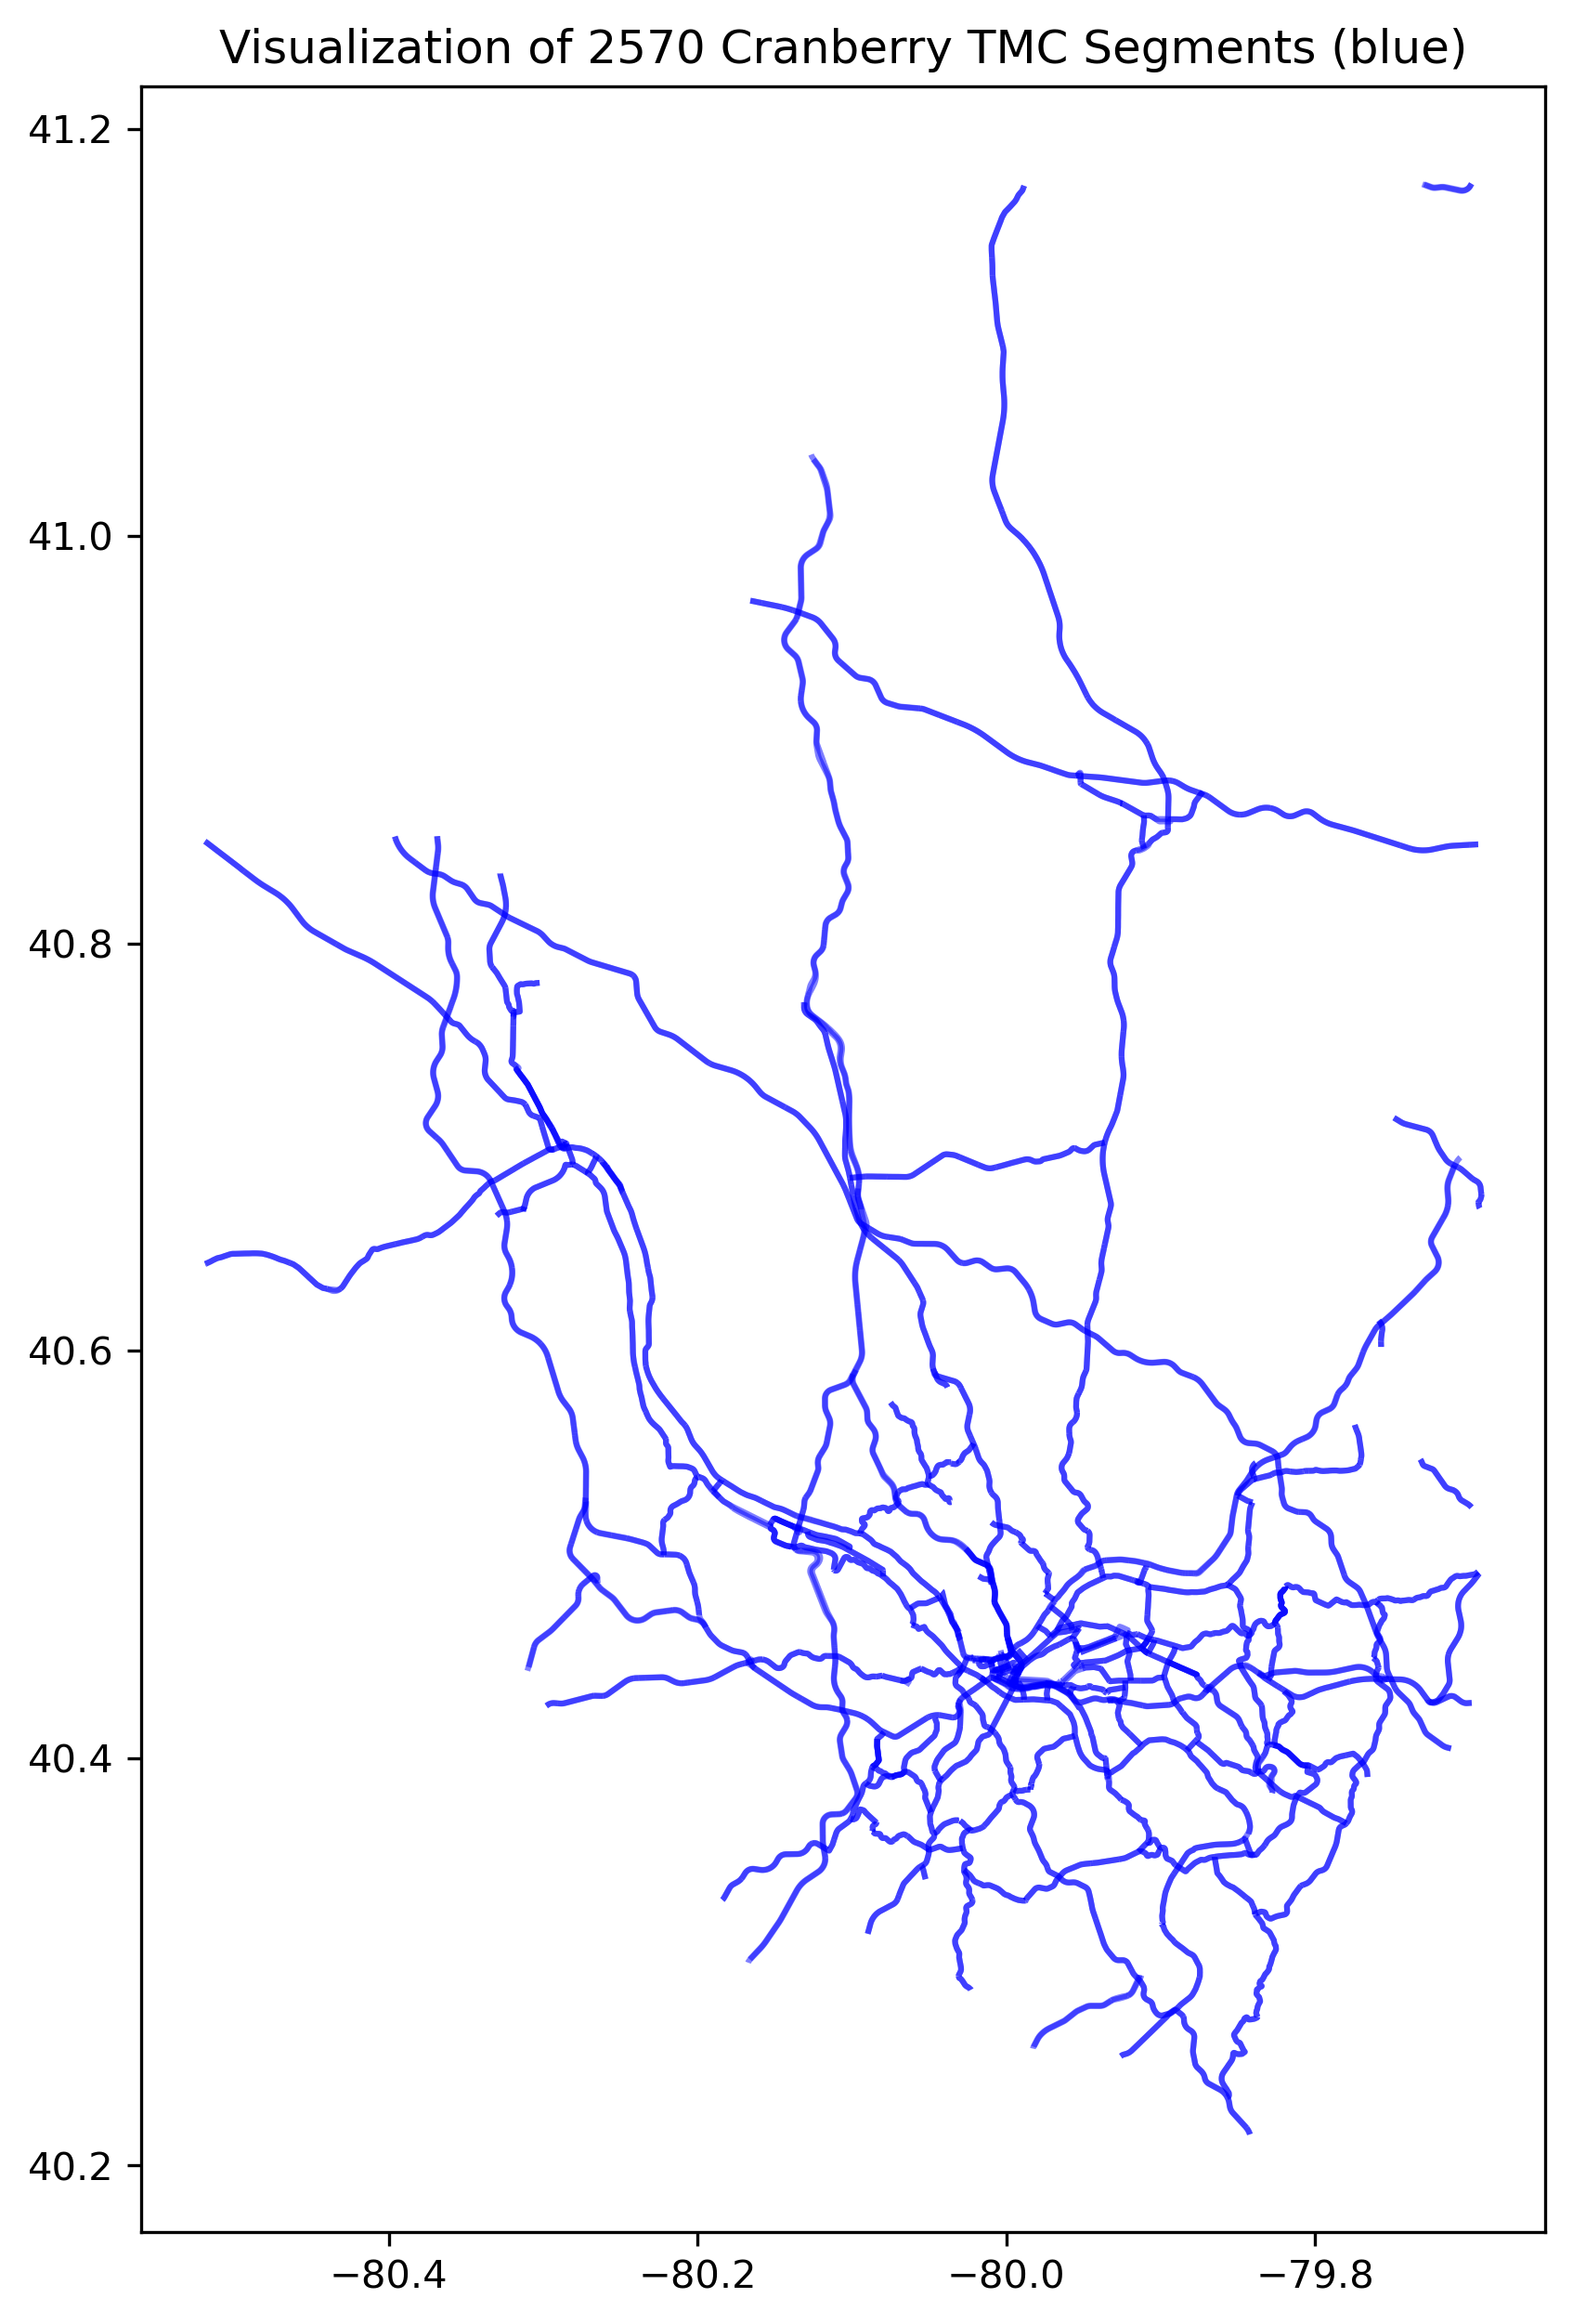

In [7]:
fig, ax = plt.subplots(1,figsize=(30,10), dpi=300)
ax.set_title(f"Visualization of {gdf_shp_tmc_all.shape[0]} {country_name} TMC Segments (blue)")
gdf_shp_tmc_all.plot(ax=ax, color="blue", alpha=0.5)

### 1.2 Select Analysis Region by QGIS
### Attention! This step should be done manually.

In [8]:
# TMC Shapefile
# gdf_shp_tmc = gpd.read_file('TSMO_tmc_shape_for_sjoin.geojson') 
gdf_shp_tmc = gpd.read_file(f'{model_path}/data/{country_name}/geo_info/{country_name}_tmc_shape_for_sjoin.geojson')
gdf_shp_tmc = gdf_shp_tmc.rename(columns={"tmc":"id_tmc"})
gdf_shp_tmc = gdf_shp_tmc.round(decimals=round_decimals)  # round up to 5 decimal place to avoid mismatch due to mathematical precision
set_shp_tmc_segments = set(gdf_shp_tmc.id_tmc) 

<Axes: title={'center': 'Visualization of 1591 Cranberry TMC Segments (orange)'}>

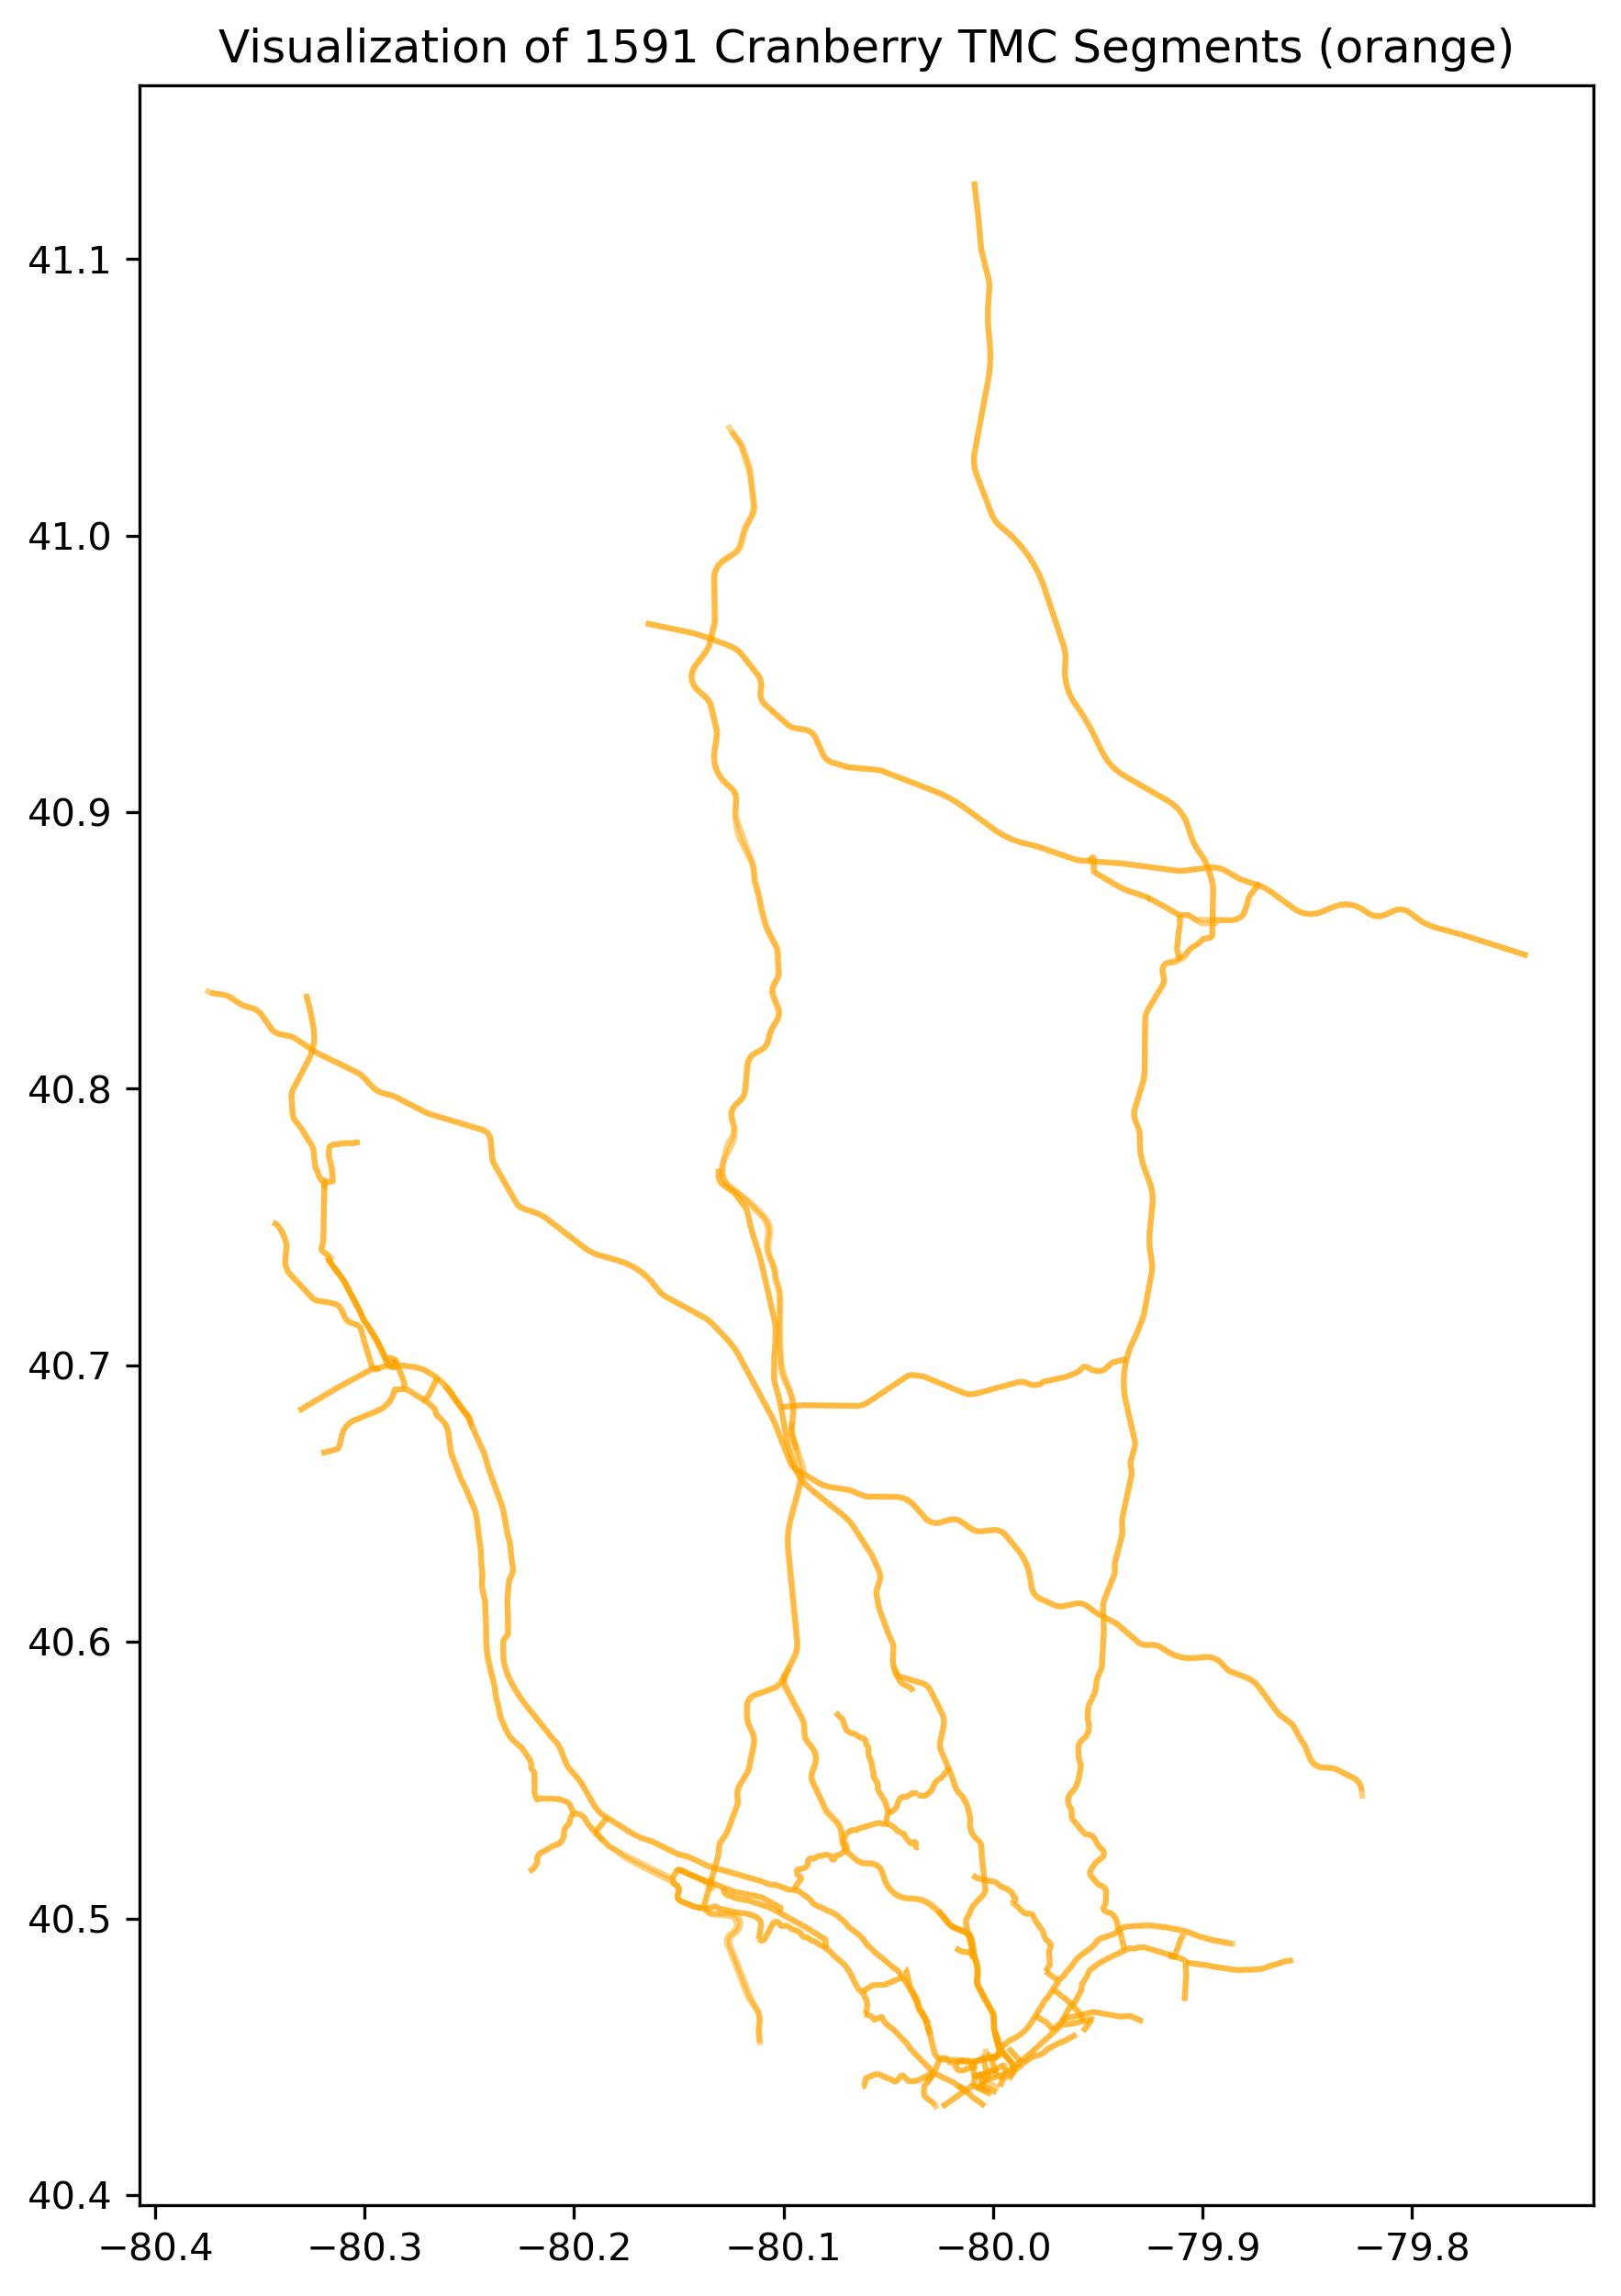

In [9]:
# Visualize TMC segments covered in different sources
fig, ax = plt.subplots(1,figsize=(30,10), dpi=300)
ax.set_title(f"Visualization of 1591 {country_name} TMC Segments (orange)")
gdf_shp_tmc.plot(ax=ax, color="orange", alpha=0.5)

In [10]:
dict_miles_tmc = dict(gdf_shp_tmc_all[["id_tmc", "miles"]].values)

In [11]:
pickle.dump(dict_miles_tmc, open(f"./geo_processing/{country_name}_dict_miles_tmc_for_upstream.pkl", "wb"))

### 1.2 Calculate immediate prev and next neighbors for each TMC segment using their starting & ending positions

#### 1.2.1 Previous Segment

In [12]:
# Step 1. Join starting and ending positions
df_raw_prev_tmc_all = pd.merge(left=gdf_shp_tmc_all, right=gdf_shp_tmc_all, left_on=["start_latitude", "start_longitude"], right_on=["end_latitude", "end_longitude"], how="left") 
df_raw_prev_tmc_all = df_raw_prev_tmc_all[~df_raw_prev_tmc_all.id_tmc_y.isna()]  

In [13]:
# It's noted that entries in "direction" column is not "clean"
# We will take care of them in manual checking of direction/angle.
df_raw_prev_tmc_all.direction_x.unique()  

array(['SOUTHBOUND', 'WESTBOUND', 'EASTBOUND', 'FORBES AVE EASTBOUND',
       '2ND AVE WESTBOUND', 'NORTHBOUND',
       'BOULEVARD OF THE ALLIES EASTBOUND', 'ANDERSON ST',
       'CROSSTOWN BLVD SOUTHBOUND', 'FORBES AVE AND 6TH ST NORTHBOUND',
       'I-279 SOUTHBOUND AND COMMONWEALTH PL SB AND FORT DUQUESNE BLVD EB',
       'I-279 NORTHBOUND', 'I-279 SOUTHBOUND',
       'BIGELOW BLVD NORTHBOUND AND I-579 NORTHBOUND',
       'I-579 NORTHBOUND AND BIGELOW BLVD NB AND WASHINGTON PL SB',
       'I-579 NORTHBOUND',
       'BIGELOW BLVD NORTHBOUND AND CHATHAM SQ SOUTHBOUND',
       'BIGELOW BLVD AND CHATHAM SQ SOUTHBOUND', 'S MAIN ST',
       'CROSSTOWN EXPY SOUTHBOUND',
       'PA-885/BOULEVARD OF THE ALLIES SOUTHBOUND',
       'PA-8/GREEN BELT/WASHINGTON BLVD SOUTHBOUND',
       'PA-8/WASHINGTON BLVD NORTHBOUND',
       'GREEN BELT/HIGHLAND PARK BRG NORTHBOUND',
       'PA-576-TPKE SOUTHBOUND', 'I-376 NORTHBOUND', 'I-79 SOUTHBOUND',
       'I-376/US-22/US-30 EASTBOUND AND US-19/BANKSVILLE

In [14]:
# Step 2. Compute angle  
df_raw_prev_tmc_all["angle"] = df_raw_prev_tmc_all.apply(lambda x: angle_neighbor(x.geometry_x, x.geometry_y), axis=1)

In [15]:
# summary of angle
df_raw_prev_tmc_all.angle.describe()

count    4441.000000
mean        0.431532
std         0.457968
min         0.000000
25%         0.010463
50%         0.085071
75%         1.000000
max         1.000000
Name: angle, dtype: float64

In [16]:
df_raw_prev_tmc_checked_angle = df_raw_prev_tmc_all[df_raw_prev_tmc_all.angle < 0.75] # 1439 starting TMC segments, (1902, 33)

In [17]:
# summary of angle
df_raw_prev_tmc_checked_angle.angle.describe()

count    2769.000000
mean        0.092685
std         0.175256
min         0.000000
25%         0.005408
50%         0.015824
75%         0.054042
max         0.748895
Name: angle, dtype: float64

<Axes: title={'center': 'Visualization of Selected Cranberry TMC Segments and segments without prev segments (in red)'}>

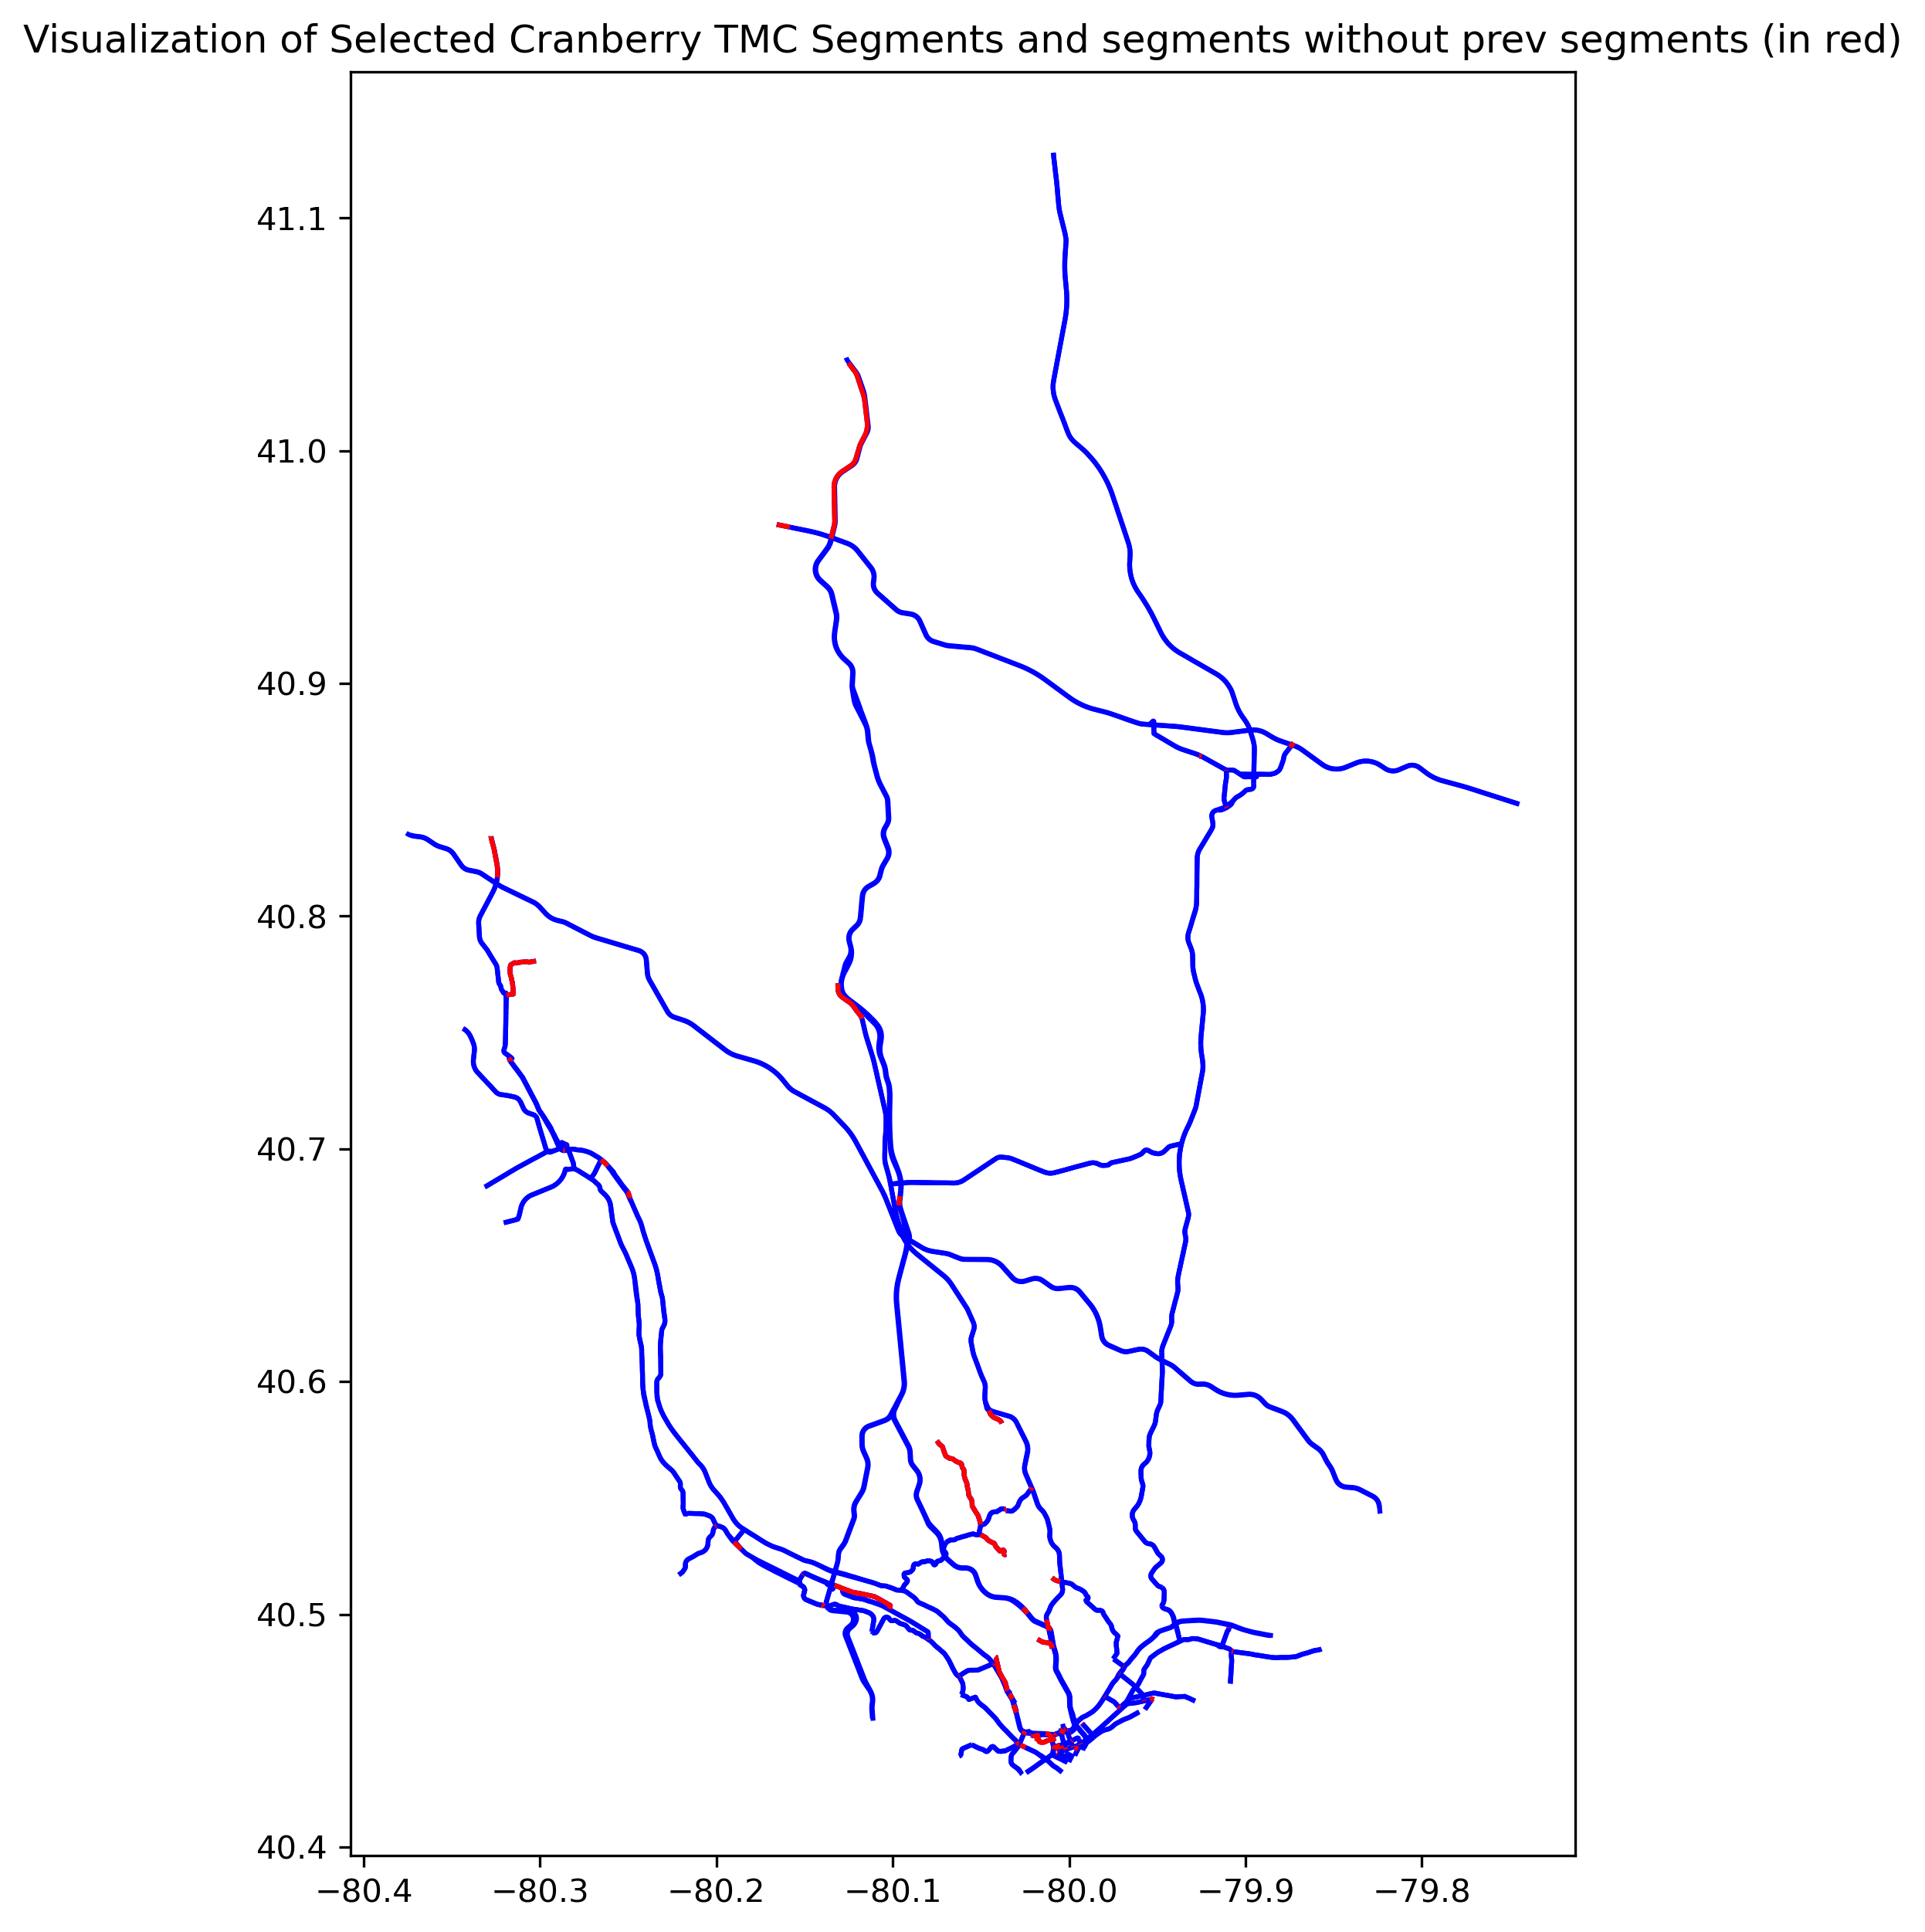

In [18]:
# Visualize TMC segments covered in different sources
fig, ax = plt.subplots(1,figsize=(30,10), dpi=300)
ax.set_title(f"Visualization of Selected {country_name} TMC Segments and segments without prev segments (in red)")
gdf_shp_tmc.plot(ax=ax, color="blue")
gdf_shp_tmc[~gdf_shp_tmc.id_tmc.isin(df_raw_prev_tmc_checked_angle.id_tmc_x)].plot(ax=ax, color="red")

<Axes: title={'center': 'Visualization of Cranberry TMC Segments, 2769 of which is covered in df_raw_prev_tmc_checked_angle'}>

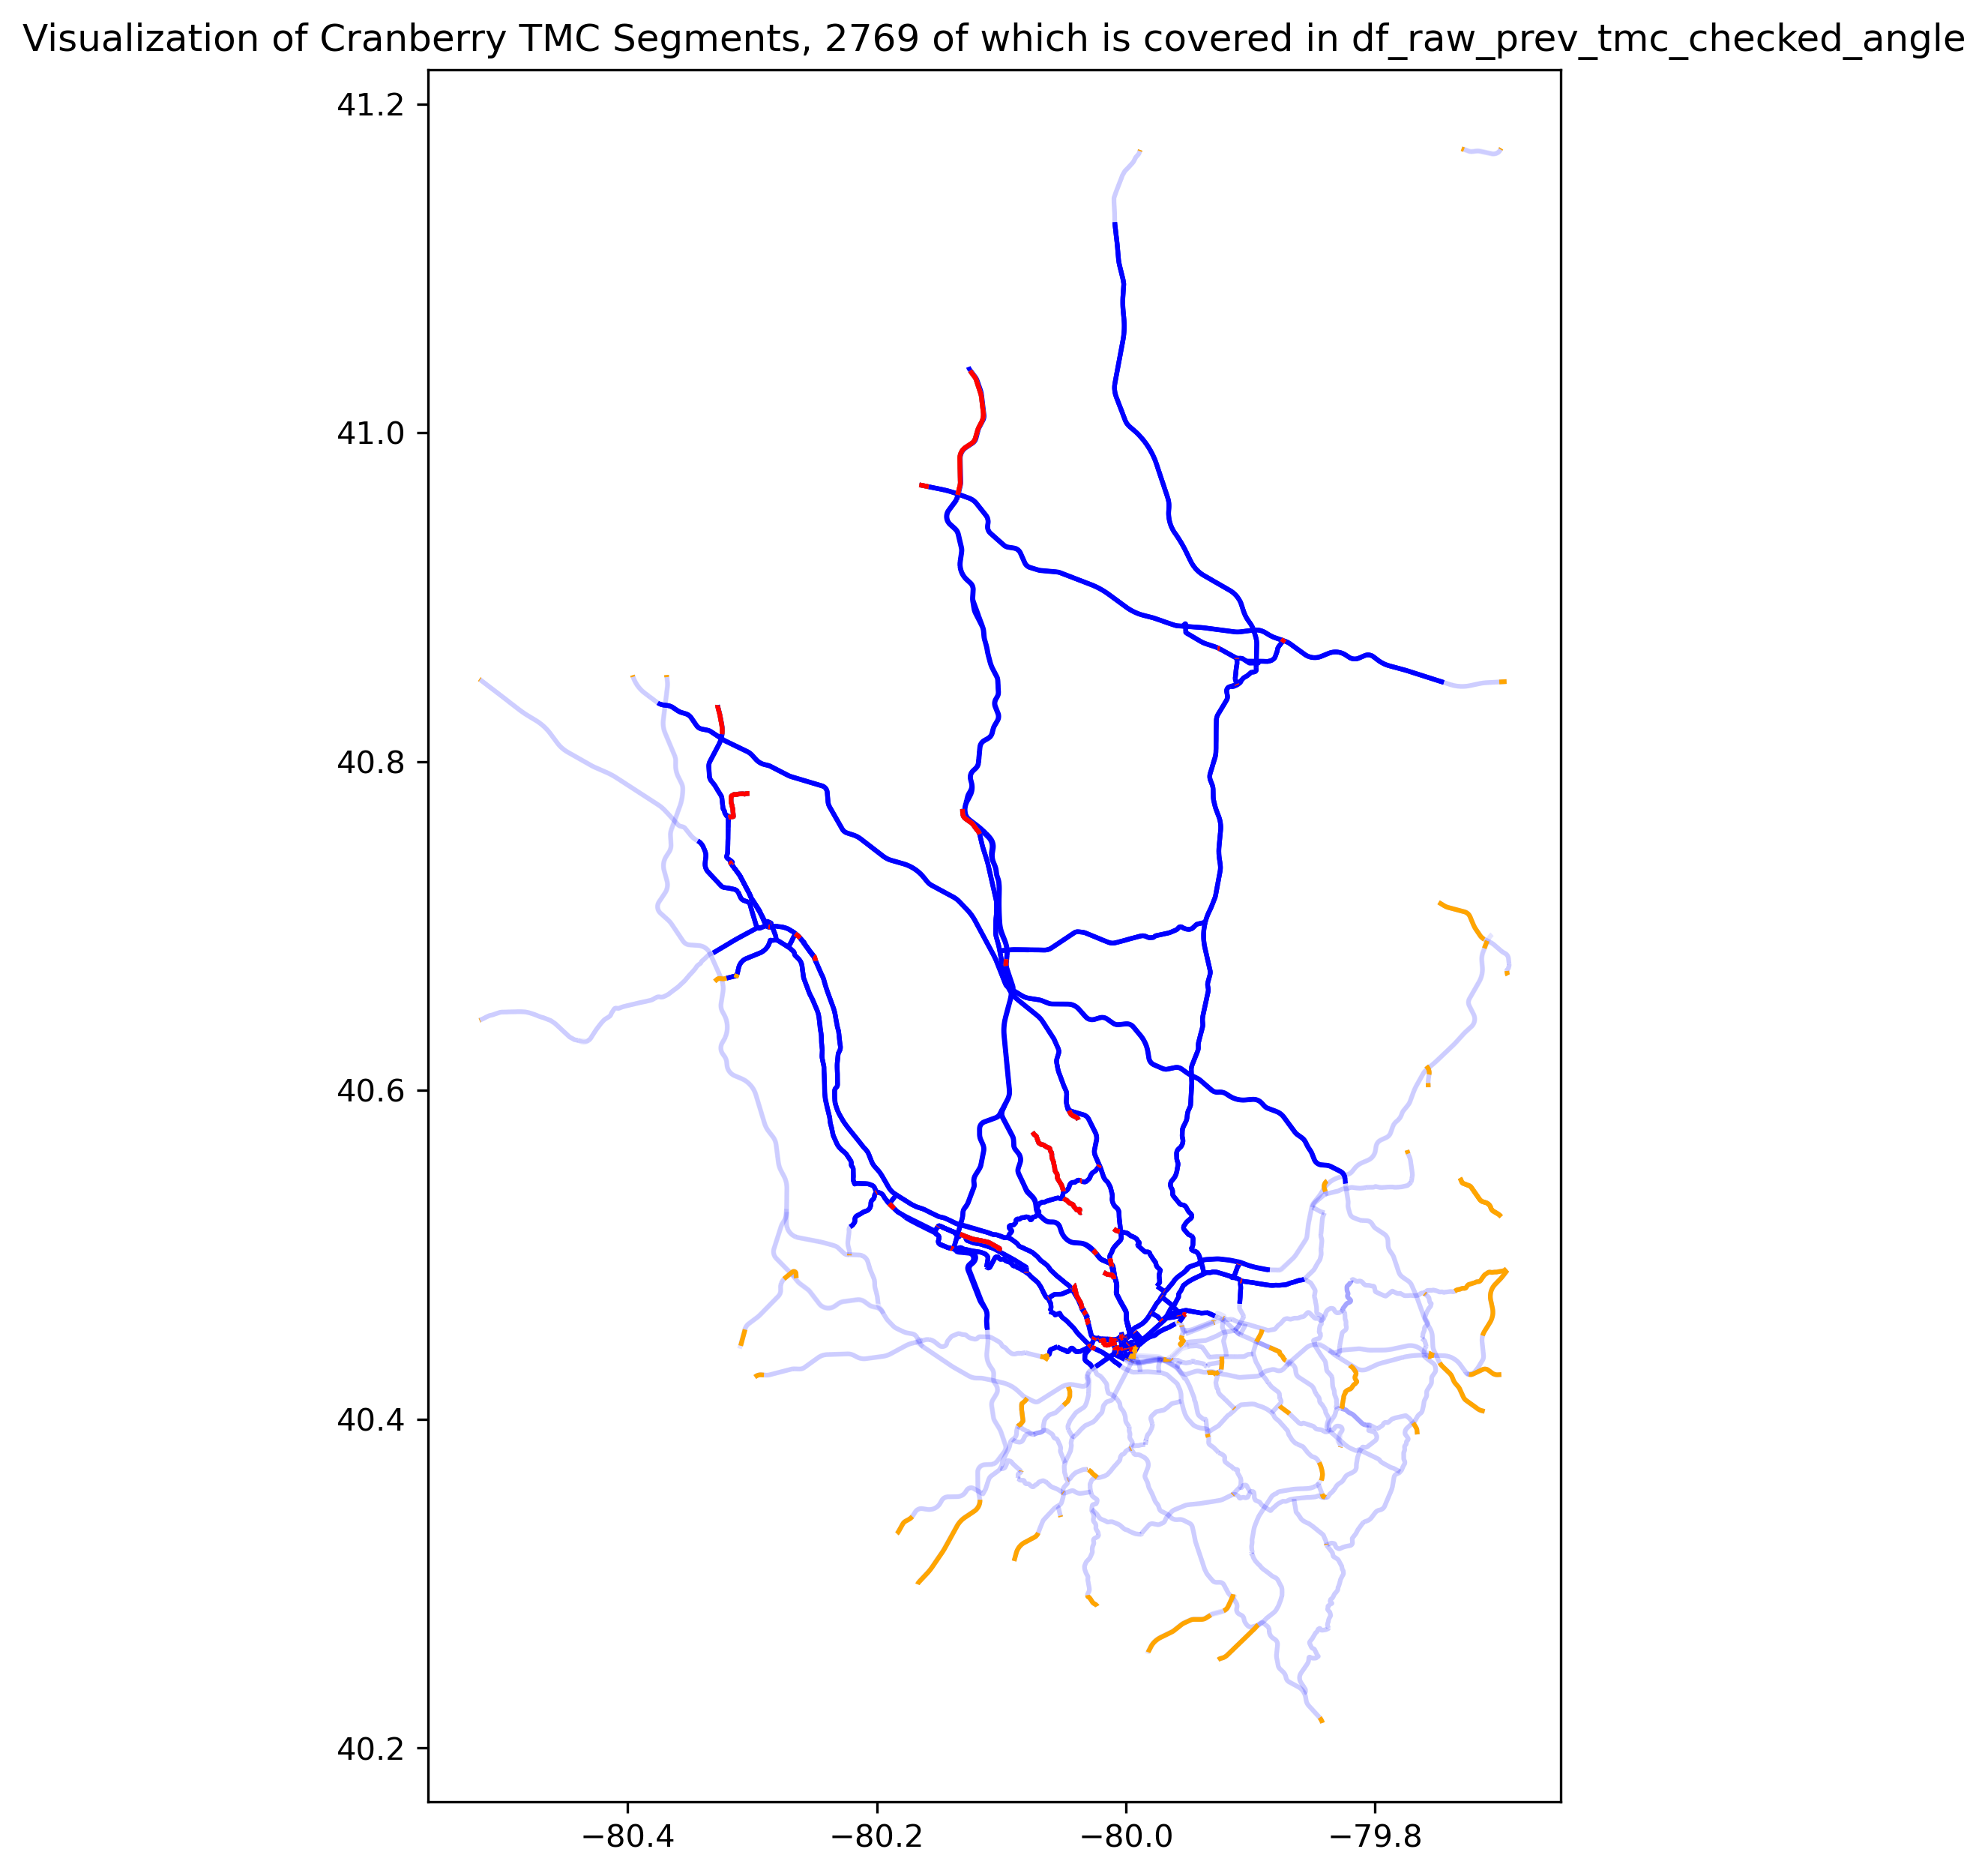

In [19]:
# Visualize TMC segments covered in different sources
fig, ax = plt.subplots(1,figsize=(30,10), dpi=300)
ax.set_title(f"Visualization of {country_name} TMC Segments, {df_raw_prev_tmc_checked_angle.angle.count()} of which is covered in df_raw_prev_tmc_checked_angle")
gdf_shp_tmc_all.plot(ax=ax, color="blue", alpha = 0.1)
gdf_shp_tmc.plot(ax=ax, color="blue")
gdf_shp_tmc_all[~gdf_shp_tmc_all.id_tmc.isin(df_raw_prev_tmc_checked_angle.id_tmc_x)].plot(ax=ax, color="orange")
gdf_shp_tmc[~gdf_shp_tmc.id_tmc.isin(df_raw_prev_tmc_checked_angle.id_tmc_x)].plot(ax=ax, color="red")

In [20]:
gdf_shp_tmc[
    ~gdf_shp_tmc['id_tmc'].isin(df_raw_prev_tmc_checked_angle['id_tmc_x']) & 
    (gdf_shp_tmc['id_tmc'] == '104P13497')
]

# '104-13491', '104-09201', '104+13490', '104P11614', '104N13509', '104-13504', '104N51422', '104N51210', '104+51210', '104N04636', '104N08593', '104-09505', '104-06621', '104N06170', '104-04786'
# still need to be edited '104N13470', '104N08097', '104P08097'
# added_dict_prev_tmc['104-13508'] = ['104N13509', '104-04641']
# added_dict_prev_tmc['104+04642'] = ['104P04641', '104+13509']
# added_dict_prev_tmc['104+09211'] = ['104-13514']
# added_dict_prev_tmc['104+13515'] = ['104P13514', '104-09210']
# added_dict_prev_tmc['104P12508'] = ['104+08946']
# added_dict_prev_tmc['104-08979'] = ['104N08953', '104+08953']
# added_dict_prev_tmc['104P51833'] = ['104P08978']
# added_dict_prev_tmc['104-51421'] = ['104N51422', '104N04638']
# added_dict_prev_tmc['104P04638'] = ['104+51422']
# added_dict_prev_tmc['104P51421'] = ['104-51209']


,fid,id_tmc,miles,direction,type_x,type_y,road_order,roadname,roadnumber,county,state,zip,start_latitude,start_longitude,end_latitude,end_longitude,geometry
587,588,104P13497,0.025433,EASTBOUND,P1.11,Feature,1.0,THREE DEGREE RD,NaN,ALLEGHENY,PA,15237,40.54461,-80.03592,40.54456,-80.03544,"MULTILINESTRING ((-80.03592 40.54461, -80.0355..."


In [21]:
Start_Link_List = ['104-13491', '104-09201', '104+13490', '104P11614', '104N13509', '104-13504', '104N51422', '104N51210', '104+51210', '104N04636', '104N08593', '104-09505', '104-06621', '104N06170', '104-04786', '104-06681', '104+04734', '104N08983', '104N08101'
                  '104P50338', '104N08101', '104-51139', '104N13495', '104P13497'
                   ]
Checked_Link_list = ['104-13508', '104+04642', '104+09211', '104+13515', '104P12508', '104-08979', '104P51833', '104N13470', '104P08097', '104P04638', '104P51421']

<Axes: title={'center': 'Visualization of Selected Cranberry TMC Segments and segments without prev segments (in red)'}>

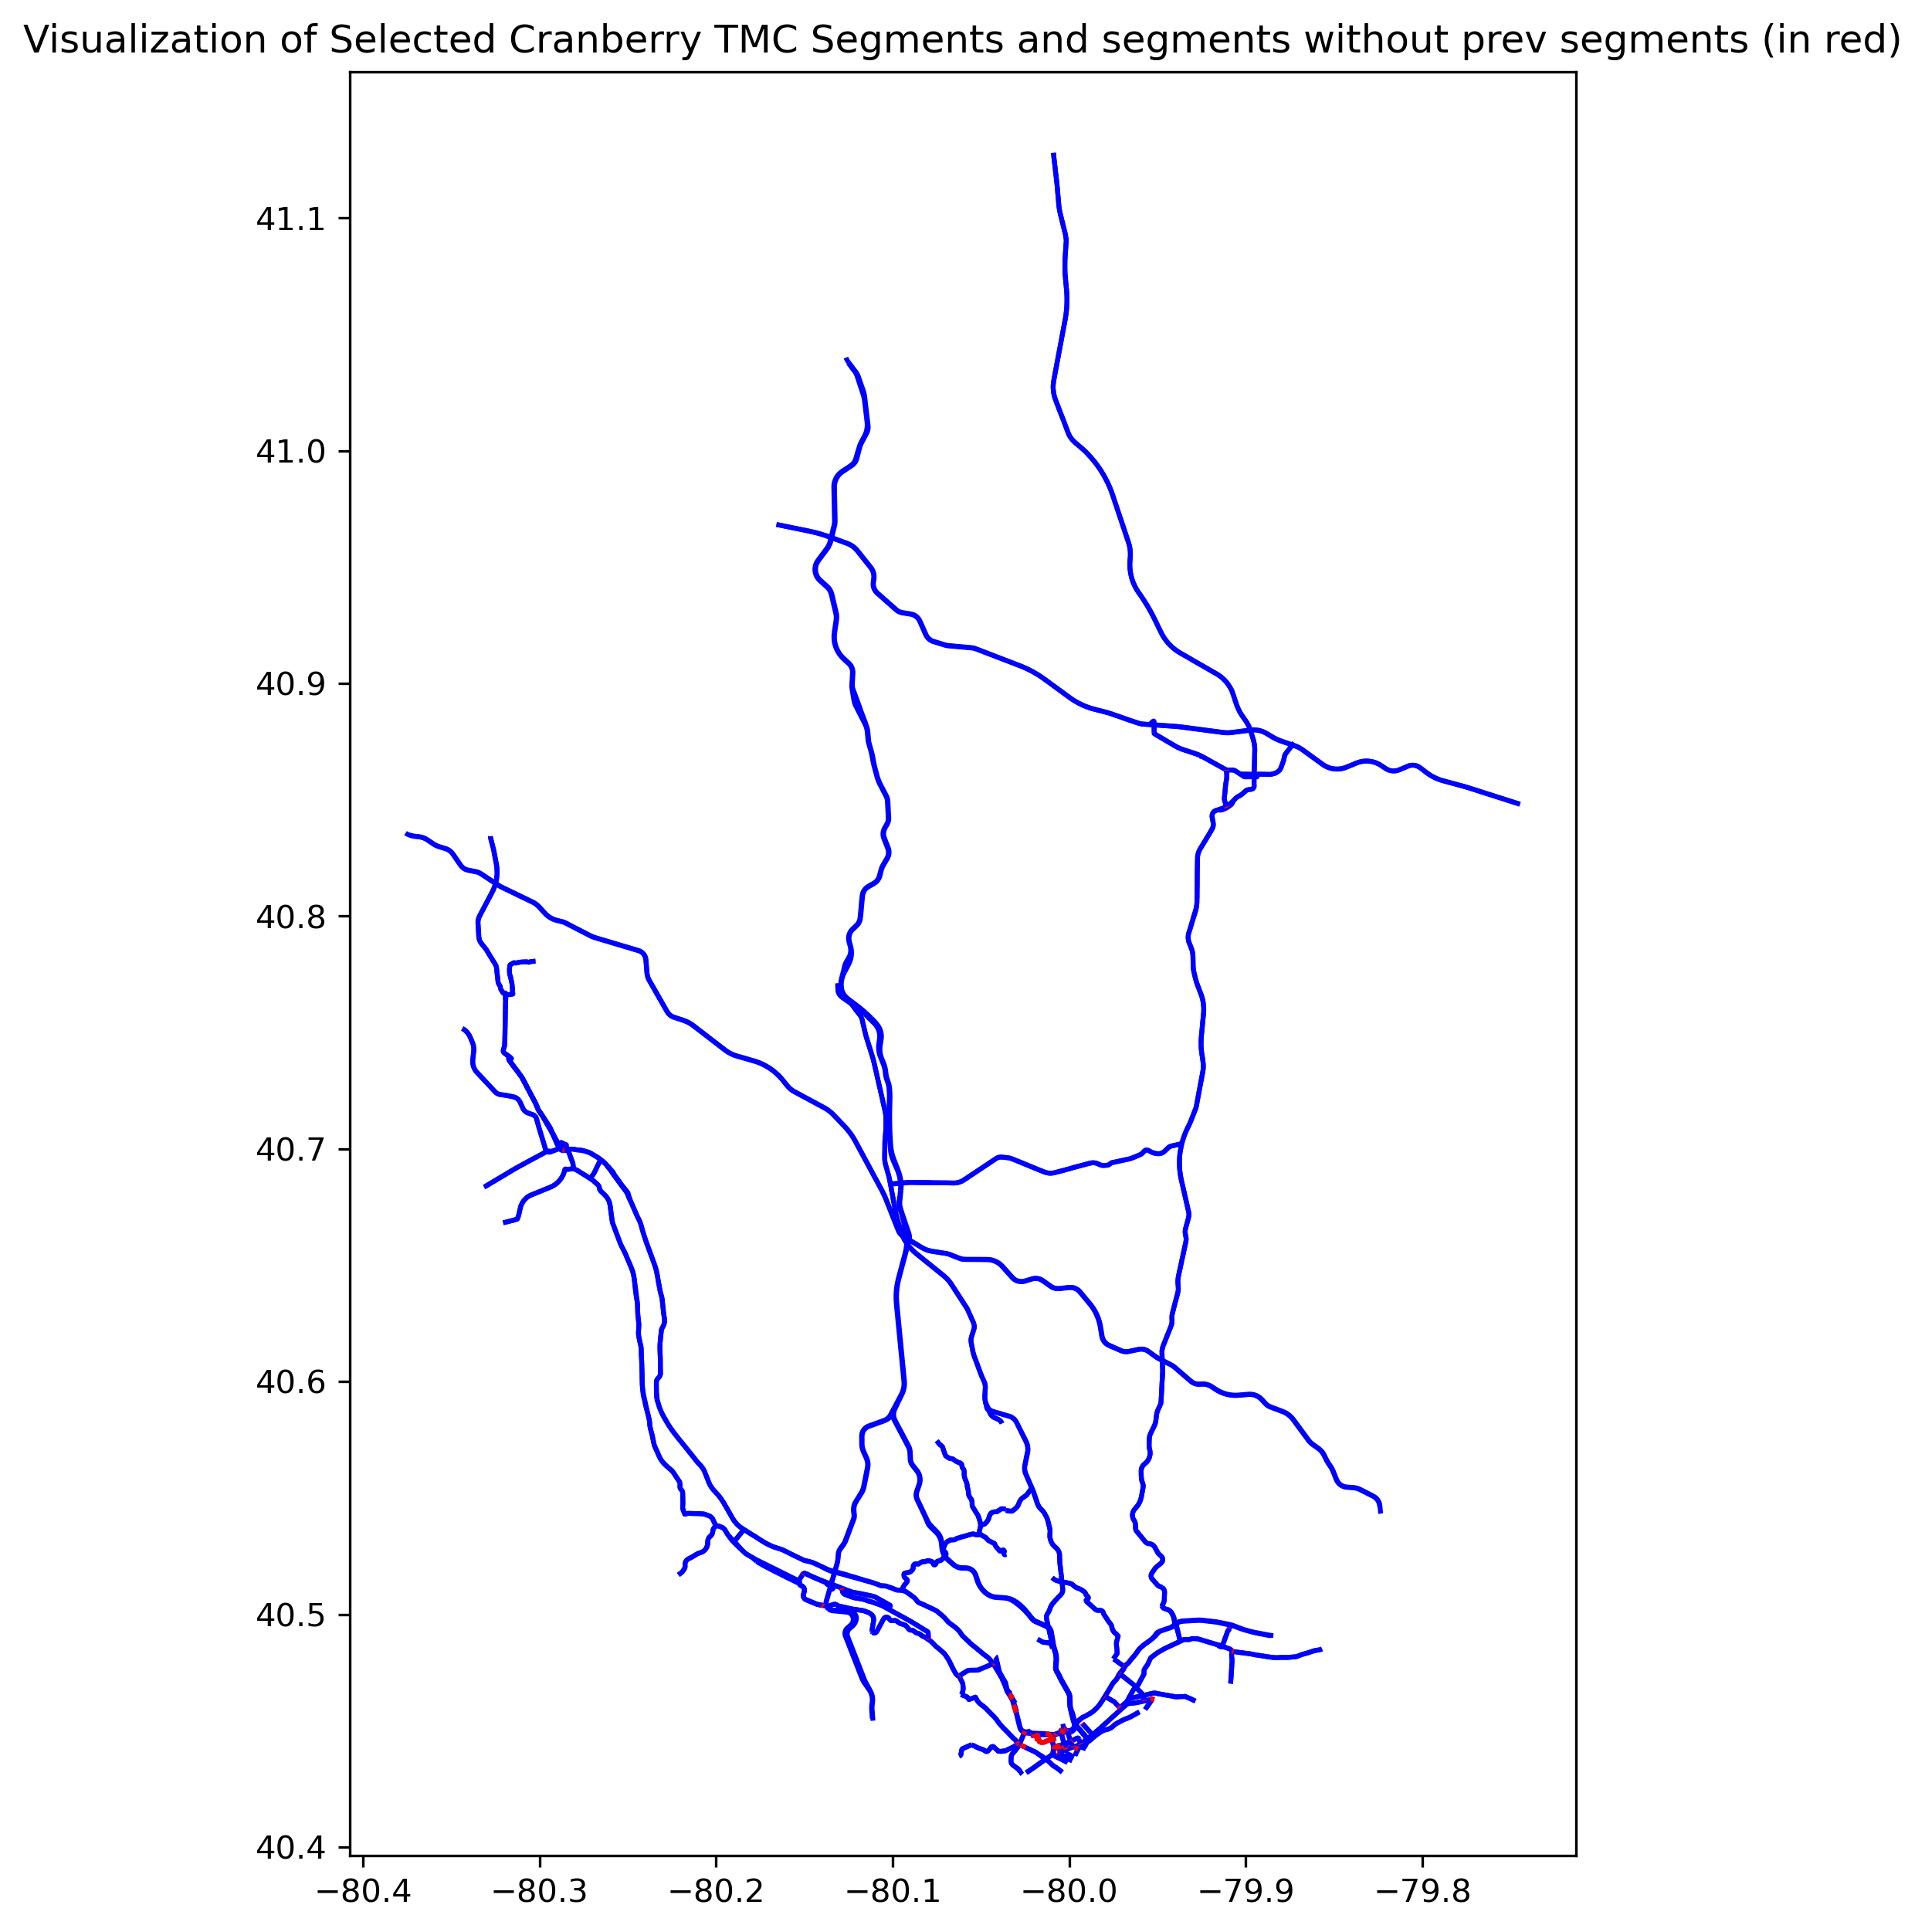

In [22]:
# Visualize TMC segments covered in different sources
fig, ax = plt.subplots(1,figsize=(30,10), dpi=300)
ax.set_title(f"Visualization of Selected {country_name} TMC Segments and segments without prev segments (in red)")
gdf_shp_tmc.plot(ax=ax, color="blue")
gdf_shp_tmc[~gdf_shp_tmc.id_tmc.isin(df_raw_prev_tmc_checked_angle.id_tmc_x) & ~gdf_shp_tmc.id_tmc.isin(Start_Link_List)& ~gdf_shp_tmc.id_tmc.isin(Checked_Link_list)].plot(ax=ax, color="red")

In [23]:
# Step 3. output raw csv file for manual checking
df_raw_prev_tmc_checked_angle.sort_values(by="id_tmc_x").to_csv(f"./geo_processing/{country_name}_raw_prev_tmc.csv", index=False)  # 1902 pairs, 518 of which have angle > 0.1

# I have decided not to auto-check direction, but manually chceck directions, as there are cases where neighbors can have opposite directions.
# df_raw_prev_tmc["direction_matchness"] = df_raw_prev_tmc.apply(lambda x: check_direction(x.direction_x, x.direction_y), axis=1)
# df_raw_prev_tmc = df_raw_prev_tmc[df_raw_prev_tmc.direction_matchness == 1].reset_index(drop=True) # includes 884 TMC segments, shape (1131, 34)

In [24]:
# Step 4. Load manually checked immediate previous segments
# df_prev_tmc = pd.read_csv(f"./geo_processing/{country_name}_prev_tmc.csv")
df_prev_tmc = df_raw_prev_tmc_checked_angle # skip manual check on csv, instead, do in jupyter notebook
df_prev_tmc = df_prev_tmc[["id_tmc_x", "id_tmc_y"]].groupby("id_tmc_x").agg(tuple).applymap(list).reset_index()
df_prev_tmc.columns = ["id_tmc", "prev_tmc"] # shape (1433, 2)

C:\Users\haowu\AppData\Local\Temp\ipykernel_1609984\145697853.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_prev_tmc = df_prev_tmc[["id_tmc_x", "id_tmc_y"]].groupby("id_tmc_x").agg(tuple).applymap(list).reset_index()


In [26]:
df_prev_tmc_multiple = df_prev_tmc[df_prev_tmc.prev_tmc.map(len) > 1]  # there are 396 TMC segments which have more than one immediate neighbors

In [27]:
df_prev_tmc_multiple

,id_tmc,prev_tmc
6,104+04437,"[104N08591, 104P04436]"
10,104+04441,"[104P04533, 104P04440]"
46,104+04526,"[104P04552, 104P04525]"
67,104+04551,"[104P50660, 104P04550]"
89,104+04595,"[104P04594, 104P04604]"
...,...,...
2353,104P50633,"[104-09106, 104P51817, 104+09106, 104+09128]"
2362,104P50662,"[104P50648, 104+50443]"
2363,104P50666,"[104-04549, 104P50662]"
2376,104P51273,"[104N51273, 104+51273]"


In [28]:
# Convert dataframe to dictionary to be saved later
dict_prev_tmc = dict(df_prev_tmc.values) # contains 1433 tmc segments, 396 of which have more than one immediate prev neighbor

<Axes: title={'center': "Visualization of 1591 TSMO TMC Segments, where 1433 (blue) have prev neighbors and 158 segment (red) don't"}>

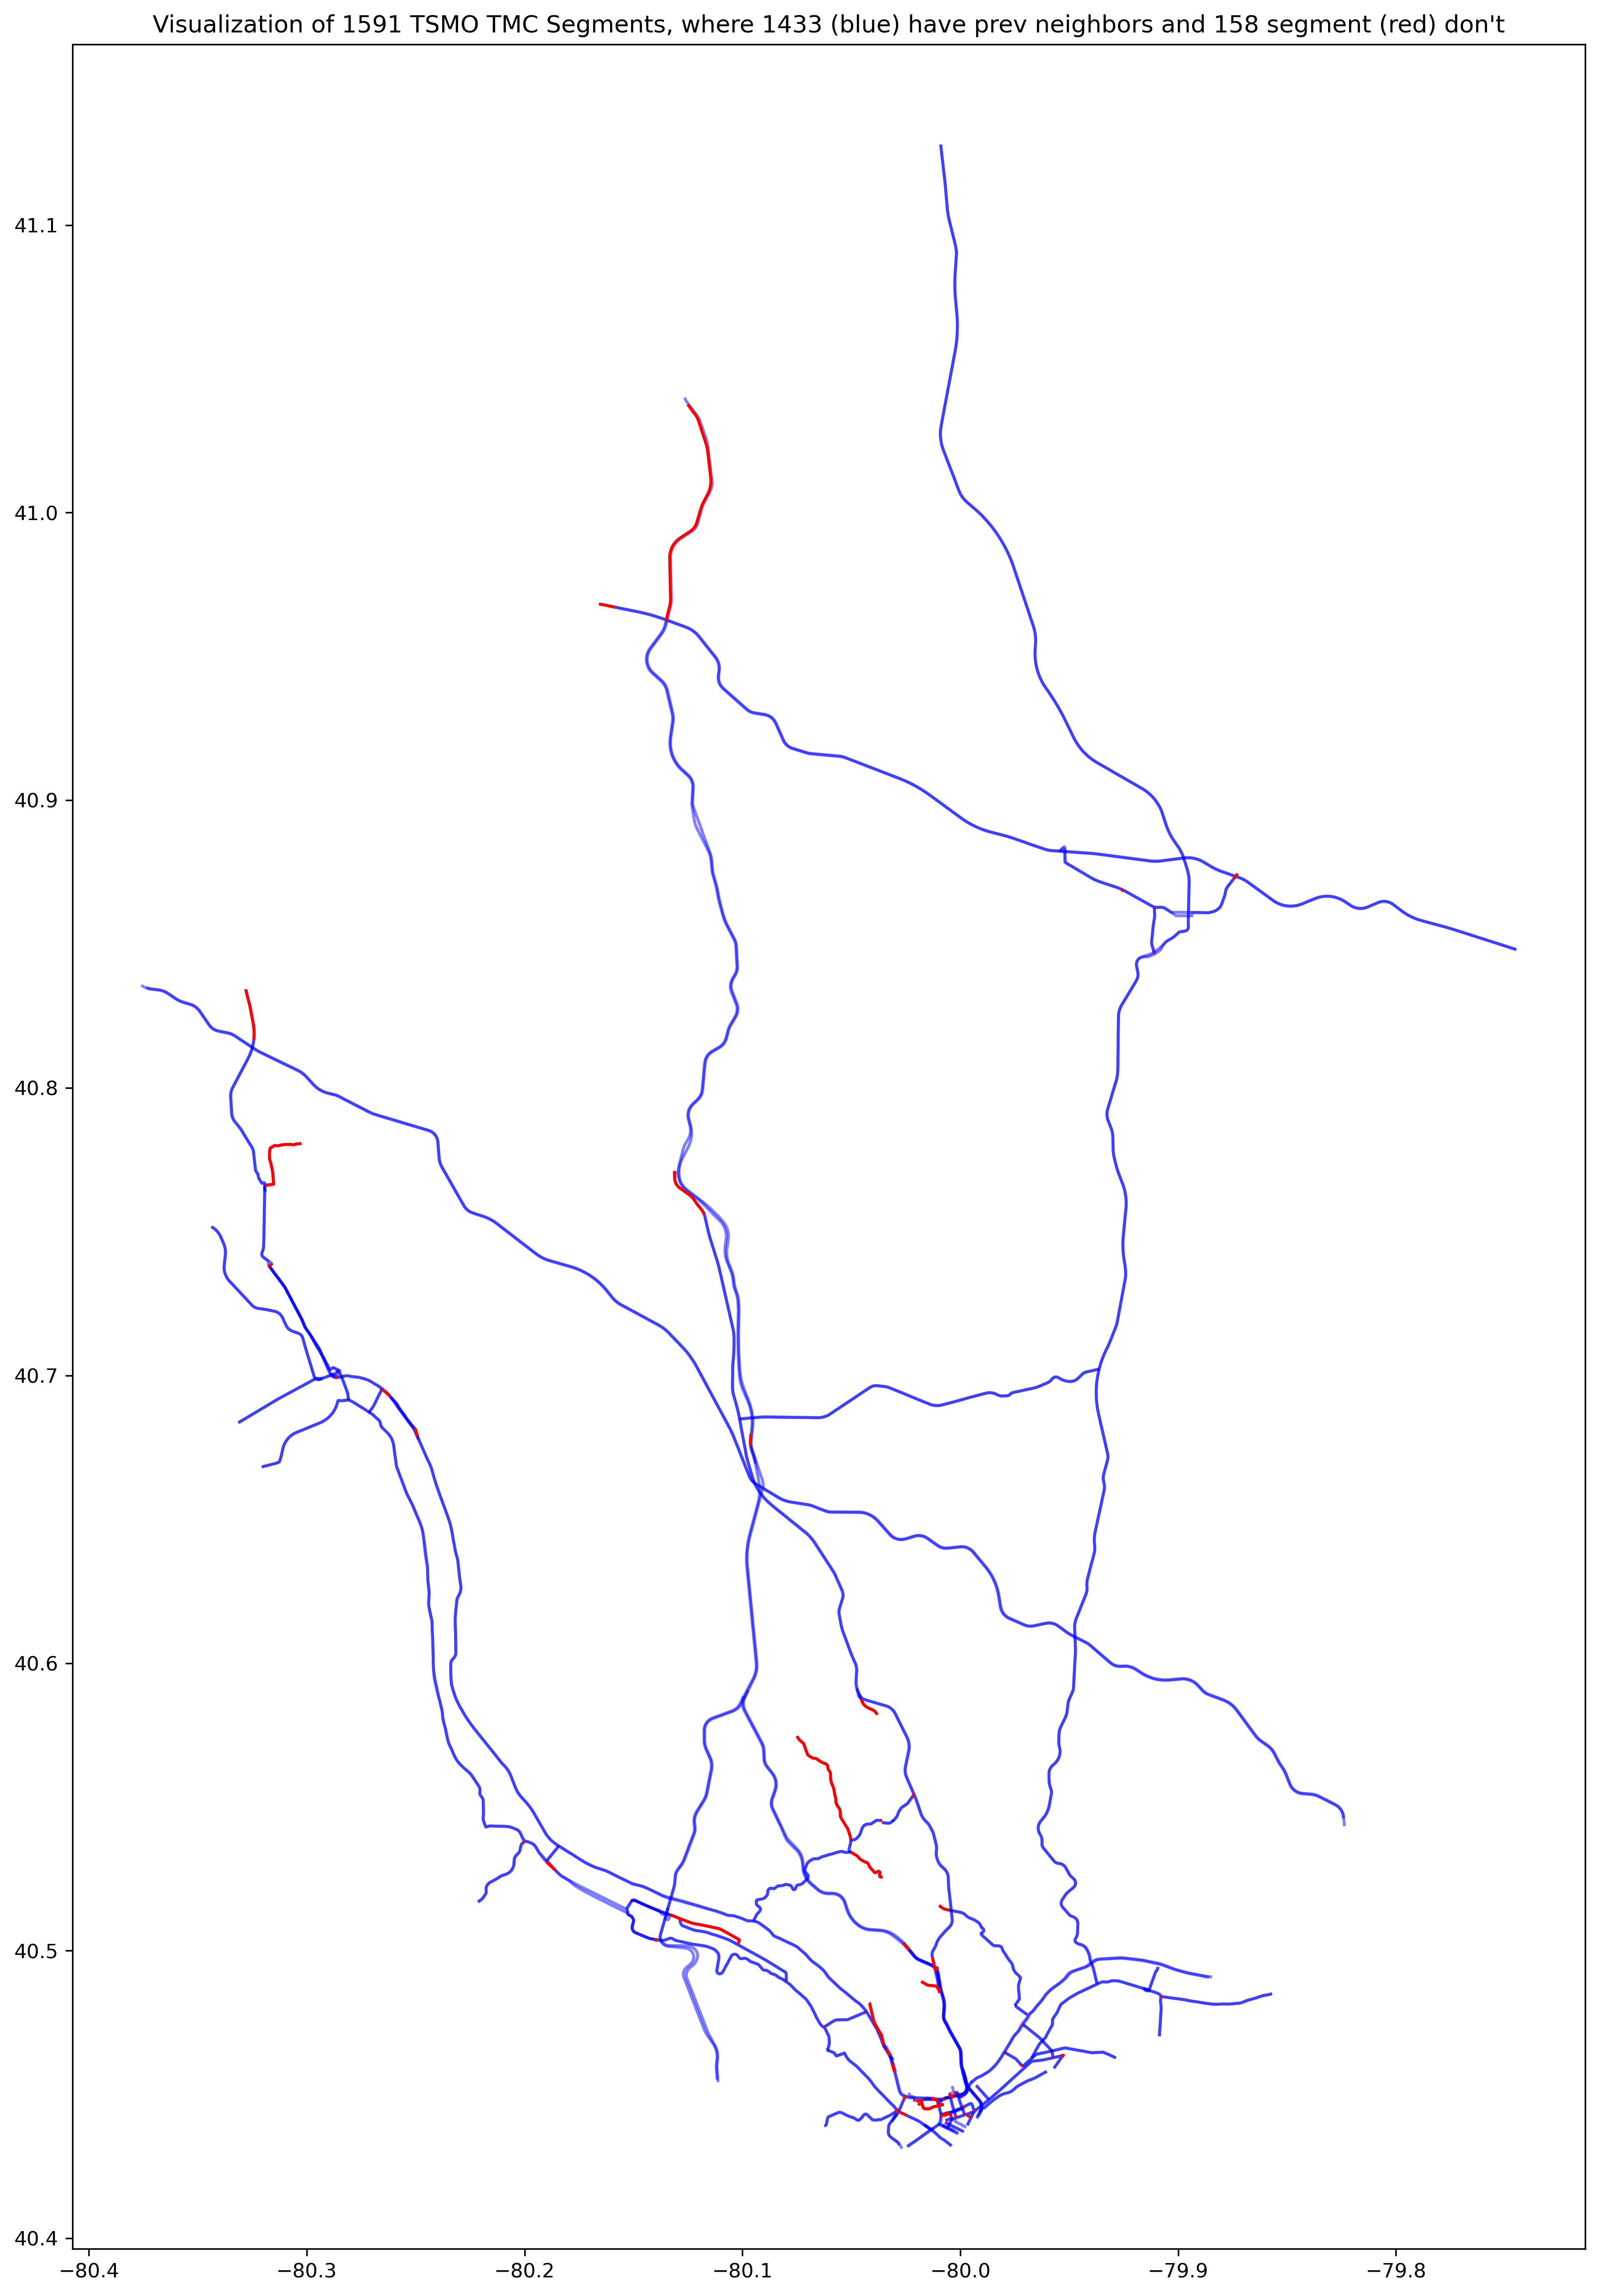

In [29]:
# Visualize and manually check segments without previous neighbors (There are 158 segments without any immediate prev neighbor)
fig, ax = plt.subplots(1,figsize=(30,20), dpi=300)
ax.set_title("Visualization of 1591 TSMO TMC Segments, where 1433 (blue) have prev neighbors and 158 segment (red) don't")
gdf_shp_tmc[gdf_shp_tmc.id_tmc.isin(dict_prev_tmc)].plot(ax=ax, color="blue", alpha=0.5)
gdf_shp_tmc[(gdf_shp_tmc.id_tmc.isin(set_shp_tmc_segments)) & (~gdf_shp_tmc.id_tmc.isin(dict_prev_tmc))].plot(ax=ax, color="red")

In [30]:
added_dict_prev_tmc = {}

In [31]:
# add manually checked linkage without pre-neighbour

added_dict_prev_tmc['104-13508'] = ['104N13509', '104-04641']
added_dict_prev_tmc['104+04642'] = ['104P04641', '104+13509']
added_dict_prev_tmc['104+09211'] = ['104-13514']
added_dict_prev_tmc['104+13515'] = ['104P13514', '104-09210']
added_dict_prev_tmc['104P12508'] = ['104+08946']
added_dict_prev_tmc['104-08979'] = ['104N08953', '104+08953']
added_dict_prev_tmc['104P51833'] = ['104P08978']
added_dict_prev_tmc['104-51421'] = ['104N51422', '104N04638']
added_dict_prev_tmc['104P04638'] = ['104+51422']
added_dict_prev_tmc['104P51421'] = ['104-51209']
added_dict_prev_tmc['104P04443'] = ['104+04443'] # not actually connected by comparing with Google Map
added_dict_prev_tmc['104P04741'] = ['104+04741'] # not actually connected by comparing with Google Map

In [32]:
for key in added_dict_prev_tmc.keys():
    dict_prev_tmc[key] = added_dict_prev_tmc[key]

<Axes: title={'center': "Visualization of Cranberry TMC Segments, where blue have prev neighbors and red don't"}>

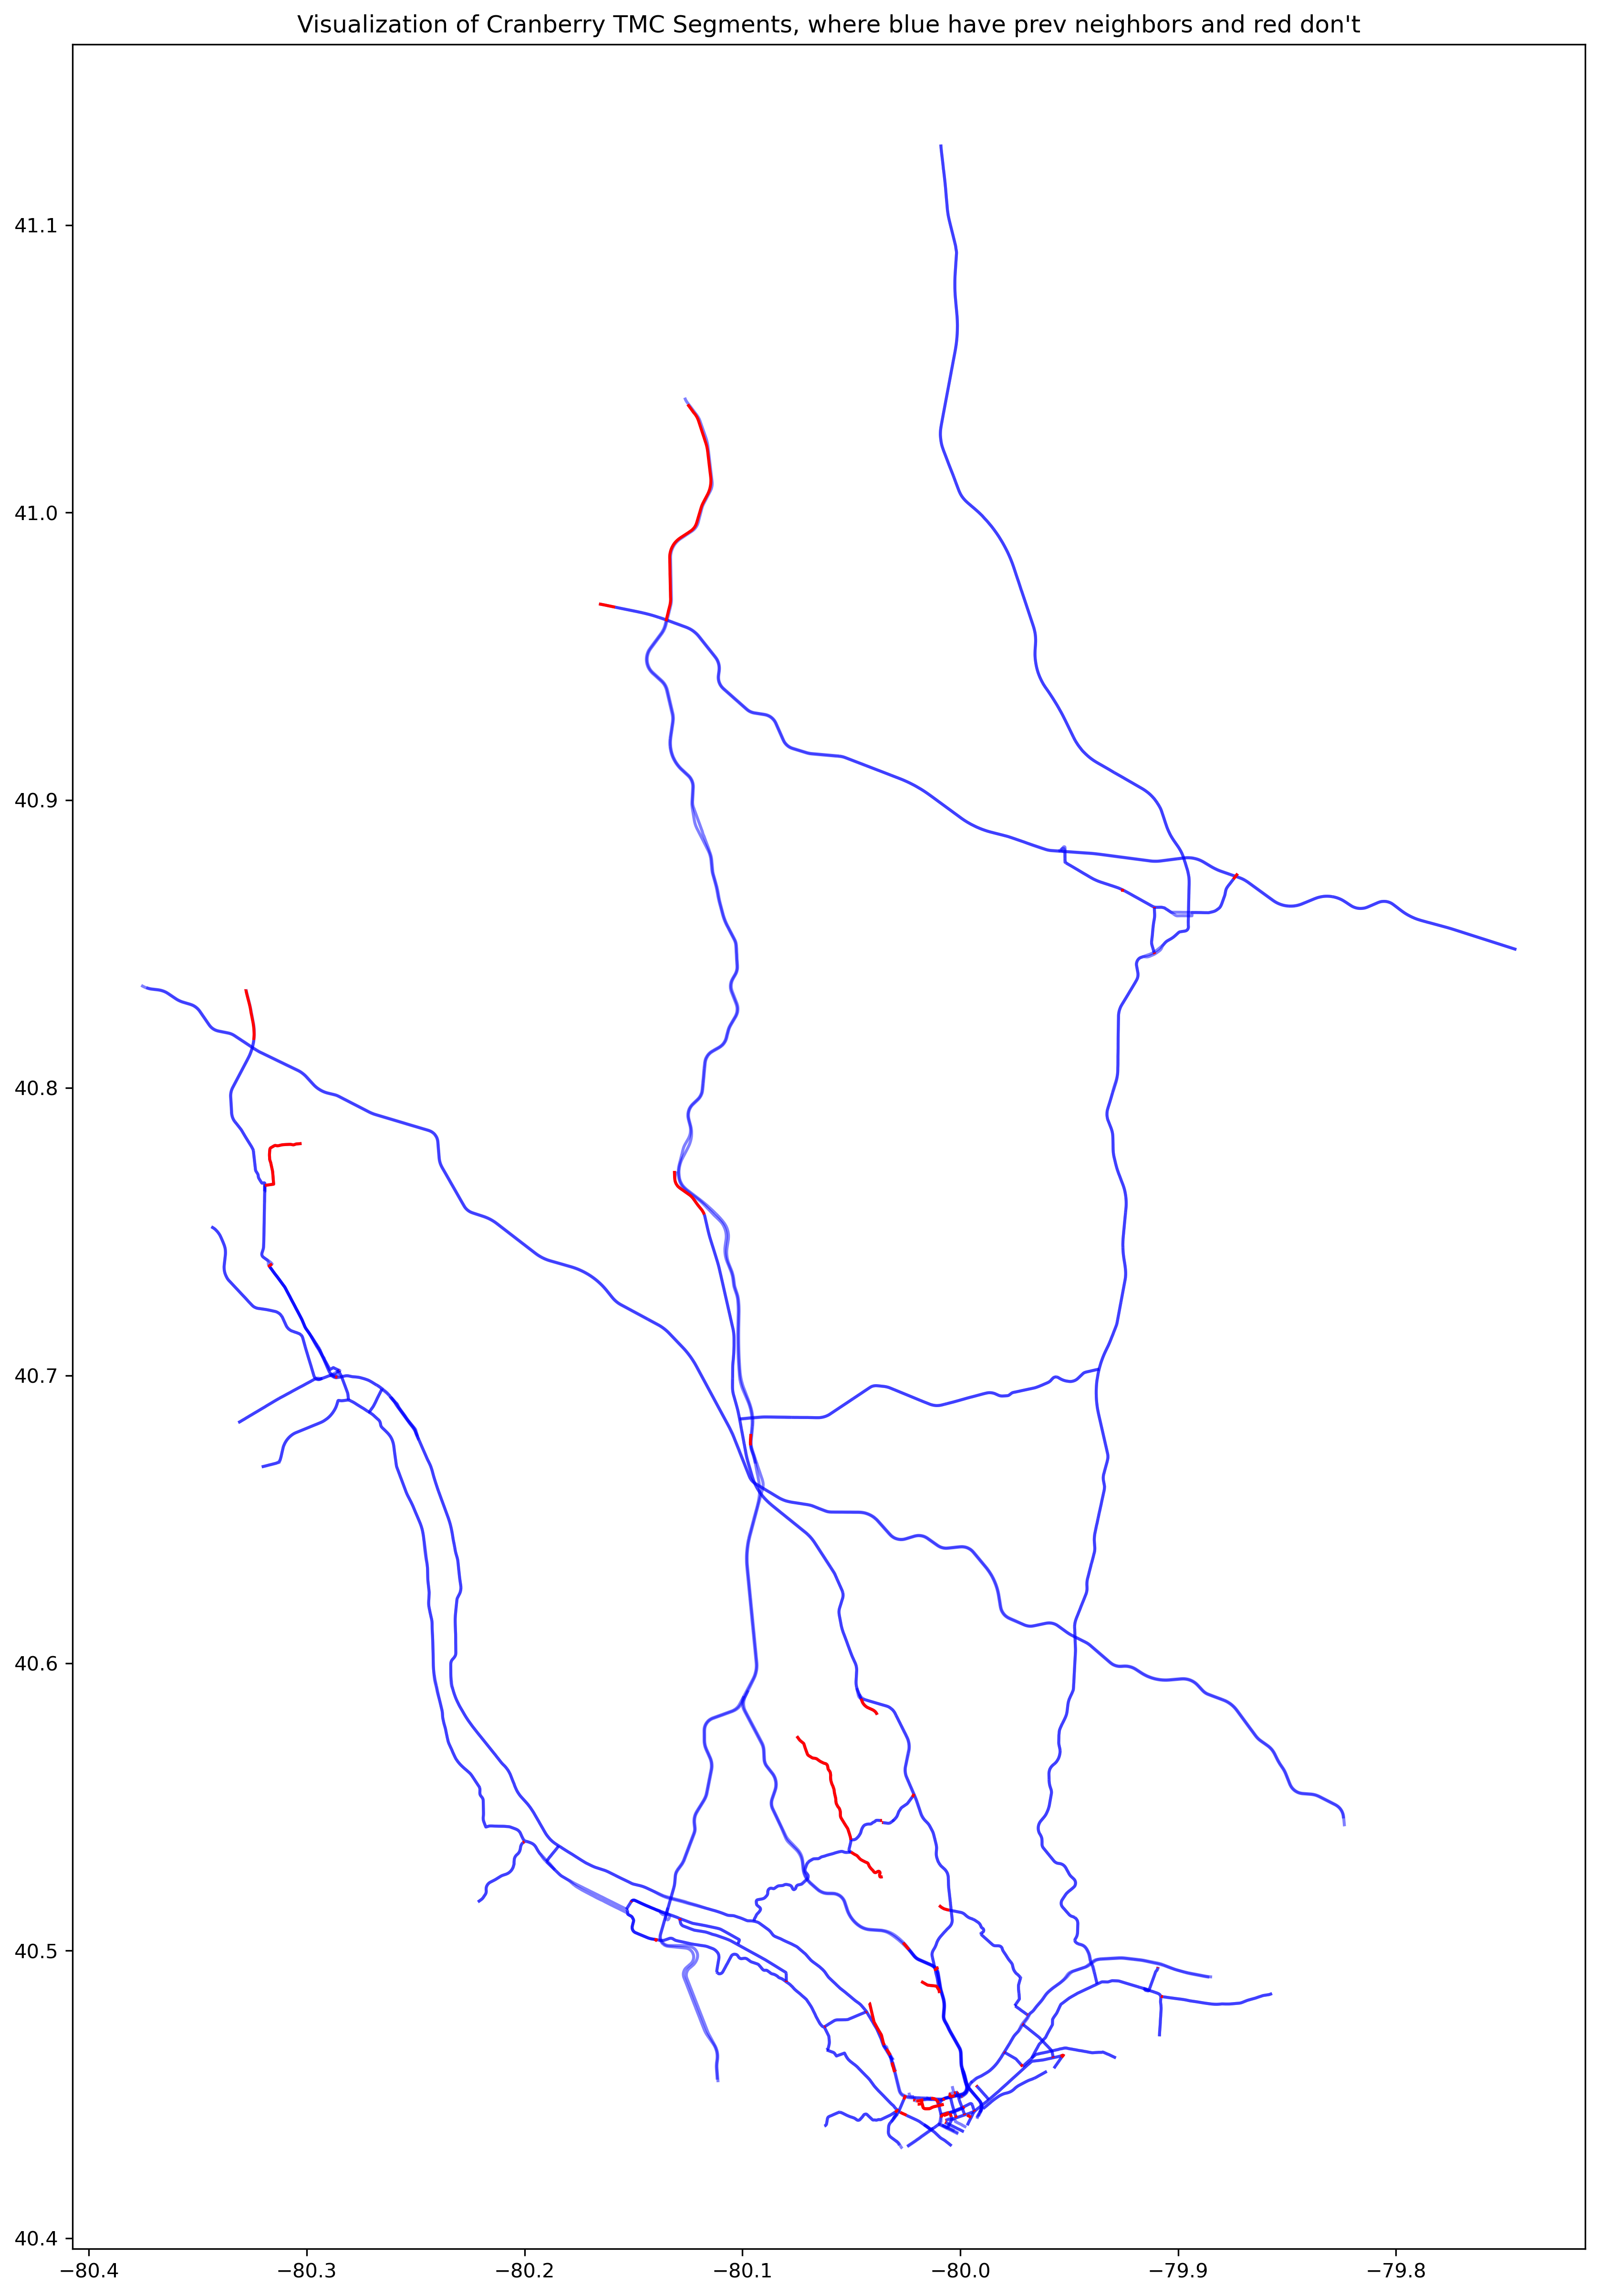

In [177]:
# Visualize and manually check segments without previous neighbors
fig, ax = plt.subplots(1,figsize=(30,20), dpi=300)
ax.set_title(f"Visualization of {country_name} TMC Segments, where blue have prev neighbors and red don't")
gdf_shp_tmc[gdf_shp_tmc.id_tmc.isin(dict_prev_tmc)].plot(ax=ax, color="blue", alpha=0.5)
gdf_shp_tmc[(gdf_shp_tmc.id_tmc.isin(set_shp_tmc_segments)) & (~gdf_shp_tmc.id_tmc.isin(dict_prev_tmc))].plot(ax=ax, color="red")

In [33]:
set_tmc_segments_with_upstream = set(dict_prev_tmc.keys())

In [34]:
f = open(f"./geo_processing/{country_name}_tmc_set_segments_with_upstream.txt", "w")
for i, k in enumerate(list(dict_prev_tmc.keys())):
    f.write(k)
    if i < len(dict_prev_tmc)-1:
        f.write(",")

In [36]:
pickle.dump(set_tmc_segments_with_upstream, open(f"./geo_processing/{country_name}_set_tmc_segments_with_upstream.pkl", "wb"))
pickle.dump(dict_prev_tmc, open(f"./geo_processing/{country_name}_dict_prev_tmc.pkl", "wb"))
pickle.dump(dict_prev_tmc, open(f"{model_path}/data/{country_name}/processed_data/{country_name}_dict_prev_tmc.pkl", "wb"))

### 1.3 Calculate upstream neighbors within certain range for each TMC segment using their immediate prev (Not used!!)

Calculate upstream neighbors without specifying range will easily break the limit of recursion depth. 

Therefore, here I specify a range of 5 miles and comupte the upstream within this range.

In [36]:
np.percentile(list(dict_miles_tmc.values()), 25), np.percentile(list(dict_miles_tmc.values()), 50), np.percentile(list(dict_miles_tmc.values()), 75)

(0.052897, 0.246173, 0.5614255)

In [37]:
# takes about 8 min to execute
dict_upstream_tmc_within_range = {}
for source in tqdm(list(set_shp_tmc_segments)):
    # dict_upstream_tmc[source] = compute_upstream(source=source, dict_prev=dict_prev_tmc, dict_upstream=dict_upstream_tmc)  # will break limit of recursion depth!!!
    dict_upstream_tmc_within_range[source] = compute_upstream_within_range(source=source, dict_prev=dict_prev_tmc, dict_upstream_within_range=dict_upstream_tmc_within_range, dict_miles=dict_miles_tmc, d=range)

100%|██████████| 1591/1591 [00:00<00:00, 132577.14it/s]


In [38]:
# convert dict of all upstream tuple to dict of unique upstream segments
dict_upstream_unique_tmc_5_miles = convert_dict_upstream_to_dict_upstream_set(dict_upstream_tmc_within_range, set_shp_tmc_segments)

100%|██████████| 1591/1591 [00:00<00:00, 794043.03it/s]


In [39]:
pickle.dump(dict_upstream_tmc_within_range, open(f"./geo_processing/{country_name}_dict_upstream_tmc_5_miles.pkl", "wb"))
pickle.dump(dict_upstream_unique_tmc_5_miles, open(f"./geo_processing/{country_name}_dict_upstream_unique_tmc_5_miles.pkl", "wb"))